# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import Identity

from r2b_data import make_traj_r2bc , make_train_r2bc
from r2b_data import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from r2b_data import make_datasets_earth, make_datasets_solar, make_datasets_r2bc

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B
from r2b import AngularMomentum0_R2B, AngularMomentum_R2B
from r2b import ConfigToPolar2D
from r2b import Motion_R2B, make_position_model_r2bc_math

from r2bc_model import make_model_r2b
from r2bc_model import make_model_r2bc_math

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/r2bc.pickle'
vartbl = load_vartbl(fname)

In [6]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r0=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [7]:
# fig, ax = plot_orbit_q(data_earth)

In [8]:
# fig, ax = plot_orbit_v(data_earth)

In [9]:
# fig, ax = plot_orbit_a(data_earth)

In [10]:
# fig, ax = plot_orbit_energy(data_earth)

### Generate data sets and an example batch

In [11]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=10000, vt_split=0.20)

# Create DataSet objects for jupiter orbits only (a=5.2, e=0)
ds_jup_trn, ds_jup_val, ds_jup_tst = make_datasets_r2bc(n_traj=1000, vt_split=0.20, 
                                                        n_years=2, r_min=5.2, r_max=5.2, seed=42, batch_size=64)

In [12]:
# Example batch
batch_in, batch_out = list(ds_earth_val.take(1))[0]
# batch_in.keys()
# batch_out.keys()

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'Example batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Example batch sizes:
t  = (64, 731)
q0 = (64, 2)
v0 = (64, 2)
mu = (64, 1)
q  = (64, 731, 2)
v  = (64, 731, 2)
a  = (64, 731, 2)
H  = (64, 731)
L  = (64, 731)


In [13]:
batch_size = 64
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 2),
    v0: (batch_size, 2),
    mu: (batch_size, 1),
    # Outputs
    q: (batch_size, traj_size, 2),
    v: (batch_size, traj_size, 2),
    a: (batch_size, traj_size, 2),
    q0_rec: (batch_size, 2),
    v0_rec: (batch_size, 2),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size),
    })

**Call layers with physics computations**

In [14]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [15]:
U = PotentialEnergy_R2B()([q, mu])
U.shape

TensorShape([64, 731])

In [16]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731])

In [17]:
L0 = AngularMomentum0_R2B()([q0, v0])
L0.shape

TensorShape([64, 1])

**Conversion of initial configuration to polar coordinates**

In [18]:
r0, theta0, omega0 = ConfigToPolar2D()([q0, v0])
print(f'shape of polar batches')
print(f'r0 : {r0.shape}')
print(f'theta0 : {theta0.shape}')
print(f'omega0 : {omega0.shape}')

shape of polar batches
r0 : (64, 1)
theta0 : (64, 1)
omega0 : (64, 1)


### Mathematical Model
**Compute position as a function of time from initial polar coordinates**

In [19]:
position_model = make_position_model_r2bc_math(traj_size)

In [20]:
# Need to call the position model on RESHAPED t vector
# t_vec = tf.reshape(t, (batch_size, traj_size, 1))
# print(f'shape of t_vec = {t_vec.shape}')

In [21]:
pos_model_out = position_model([t, r0, theta0, omega0])
out_names = ['qx', 'qy']
for i, x in enumerate(pos_model_out):
    print(f'{out_names[i]} : {x.shape}')

qx : (64, 731, 1)
qy : (64, 731, 1)


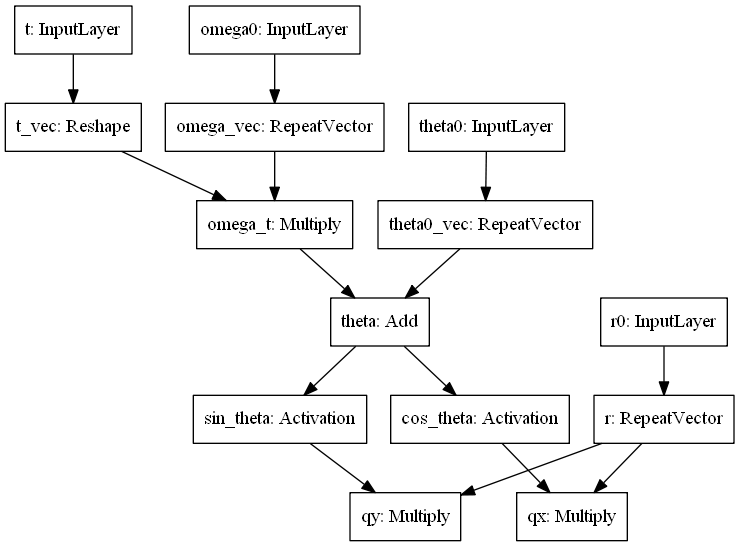

In [22]:
keras.utils.plot_model(position_model)

In [23]:
position_model.summary()

Model: "model_r2bc_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
omega0 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
omega_vec (RepeatVector)        (None, 731, 1)       0           omega0[0][0]                     
__________________________________________________________________________________________________
t_vec (Reshape)                 (None, 731, 1)       0           t[0][0]                          
____________________________________________________________________________________

**Motion Model: Compute v and a from q using automatic differentiation**<br>
Factory function that accepts any position model<br>
Instantiated here from mathematical position model

In [24]:
motion_model = Motion_R2B(position_model=position_model, name='motion_model')

In [25]:
q, v, a = motion_model([t, r0, theta0, omega0])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


In [26]:
# keras.utils.plot_model(motion_model)

In [27]:
# motion_model.summary()

**Full physics model: computes energy and angular momentum from q, v**<br>
Factory function that accepts any position model.<br>
Instantiated here from mathematical position model.

In [28]:
model_math = make_model_r2bc_math()
# model_math = make_model_r2b(position_model=position_model, traj_size=traj_size)

In [29]:
# keras.utils.plot_model(model_math)

In [30]:
# model_math.summary()

In [31]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 2)
v = (64, 731, 2)
a = (64, 731, 2)
q0_rec = (64, 2)
v0_rec = (64, 2)
H = (64, 731)
L = (64, 731)


In [32]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(name='q_mse'),
        'v': keras.losses.MeanSquaredError(name='q_mse'),
        'a': keras.losses.MeanSquaredError(name='a_mse'),
        'q0_rec': keras.losses.MeanSquaredError(name='q0_mse'),
        'v0_rec': keras.losses.MeanSquaredError(name='v0_mse'),
        'H': keras.losses.MeanSquaredError(name='H'),
        'L': keras.losses.MeanSquaredError(name='L')}

# these metrics produce crazy output names when multiple instances share them; hold off for now
# metrics = {'q': keras.metrics.MeanAbsoluteError(name='q_mae'),
#            'v': keras.metrics.MeanAbsoluteError(name='v_mae')}
metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 0.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [33]:
# Compile the mathematical model on a single GPU
# model_math = make_model_r2bc_math()
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [34]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [35]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

32/32 [==============================] - 1s 32ms/step - loss: 1.0462e-11 - q_loss: 1.0713e-12 - v_loss: 9.3807e-13 - a_loss: 1.8915e-10 - q0_rec_loss: 6.8588e-13 - v0_rec_loss: 1.6613e-14 - H_loss: 9.0250e-13 - L_loss: 6.8472e-12


[1.046152853473141e-11,
 1.0712517e-12,
 9.380711e-13,
 1.8915272e-10,
 6.8588467e-13,
 1.6613316e-14,
 9.025031e-13,
 6.847203e-12]

In [36]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [37]:
# Time the single GPU math model
# time_model_eval(model_math, ds_solar_trn)

In [38]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_solar_trn)

In [41]:
def make_position_model_r2bc_nn(hidden_sizes, skip_layers=True, traj_size = 731):
    """
    Compute orbit positions for the restricted two body circular problem from 
    the initial polar coordinates (orbital elements) with a deterministic mathematical model.
    Factory function that returns a functional model.
    """
    # Create input layers
    t = keras.Input(shape=(traj_size,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    mu = keras.Input(shape=(1,), name='mu')
    # The combined input layers
    inputs = [t, q0, v0, mu]

    # Check sizes
    batch_size = t.shape[0]
    tf.debugging.assert_shapes(shapes={
        t: (batch_size, traj_size),
        q0: (batch_size, 2),
        v0: (batch_size, 2),
        mu: (batch_size, 1),
    }, message='make_position_model_r2bc_nn / inputs')
    
    # The polar coordinates of the initial conditions
    # r0, theta0, and omega0 each scalars in each batch
    r0, theta0, omega0 = ConfigToPolar2D(name='polar0')([q0, v0])
    
    # Name the outputs of the initial polar
    # These each have shape (batch_size, 1)
    r0 = Identity(name='r0')(r0)
    theta0 = Identity(name='theta0')(theta0)
    omega0 = Identity(name='omega0')(omega0)

    # Check sizes
    tf.debugging.assert_shapes(shapes={
        r0: (batch_size, 1),
        theta0: (batch_size, 1),
        omega0: (batch_size, 1),
    }, message='make_position_model_r2bc_nn / polar elements r0, theta0, omega0')
   
    # Reshape t to (batch_size, traj_size, 1)
    t_vec = keras.layers.Reshape(target_shape=(traj_size, 1), name='t_vec')(t)
    
    # Repeat r, theta0 and omega to be vectors of shape matching t
    r = keras.layers.RepeatVector(n=traj_size, name='r')(r0)
    theta0_vec = keras.layers.RepeatVector(n=traj_size, name='theta0_vec')(theta0)
    omega = keras.layers.RepeatVector(n=traj_size, name='omega')(omega0)

    # Check shapes
    tf.debugging.assert_shapes(shapes={
        t_vec: (batch_size, traj_size, 1),
        r: (batch_size, traj_size, 1),
        theta0_vec: (batch_size, traj_size, 1),
        omega: (batch_size, traj_size, 1)
    }, message='make_position_model_r2bc_nn / r_vec, theta0_vec, omega_vec')
    
    # The angle theta at time t
    # theta = omega * t + theta0
    omega_t = keras.layers.multiply(inputs=[omega, t_vec], name='omega_t')
    theta = keras.layers.add(inputs=[omega_t, theta0_vec], name='theta')

    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    
    # Check shapes
    batch_size = t.shape[0]
    tf.debugging.assert_shapes(shapes={
        omega_t: (batch_size, traj_size, 1),
        theta: (batch_size, traj_size, 1),
        cos_theta: (batch_size, traj_size, 1),
        sin_theta: (batch_size, traj_size, 1),
        qx: (batch_size, traj_size, 1),
        qy: (batch_size, traj_size, 1),
    }, message='make_position_model_r2bc_nn / outputs')
    
    # Wrap this into a model
    outputs = [qx, qy]
    model = keras.Model(inputs=inputs, outputs=outputs, name='model_r2bc_nn')
    return model

In [42]:
position_model_nn = make_position_model_r2bc_nn([16])

In [43]:
position_model_nn.summary()

Model: "model_r2bc_nn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
omega0 (Identity)               (None, 1)            0           polar0[0][2]         

In [44]:
qx, qy = position_model([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 2)
qy = (64, 731, 2)


In [45]:
qx, qy = position_model_nn([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)


In [46]:
def make_model_r2bc_nn(hidden_sizes, skip_layers=True, traj_size: int = 731):
    """Create a neural net model for the restricted two body circular problem"""
    # Build the position model
    position_model = make_position_model_r2bc_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers)
    
    # Build the model with this position model and the input trajectory size
    return make_model_r2b(position_model=position_model, traj_size=traj_size)

In [48]:
model_math = make_model_r2b(position_model=position_model_nn, traj_size=traj_size)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

ValueError: in converted code:

    D:\IACS\Thesis\src\r2b.py:217 call  *
        qx, qy = self.position_model(position_inputs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:662 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    D:\IACS\Thesis\src\r2b.py:145 call  *
        arg_func = lambda q : tf.reshape(tensor=tf.atan2(y=q[:,1], x=q[:,0]), shape=(-1, 1,))
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:662 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py:785 call
        return self.function(inputs, **arguments)
    C:\Users\Michael\AppData\Local\Temp\tmp6d8jz_np.py:12 <lambda>
        arg_func = lambda q: ag__.converted_call('reshape', tf, ag__.ConversionOptions(recursive=True, force_conversion=False, optional_features=(), internal_convert_user_code=True), (), {'tensor': ag__.converted_call('atan2', tf, ag__.ConversionOptions(recursive=True, force_conversion=False, optional_features=(), internal_convert_user_code=True), (), {'y': q[:, (1)], 'x': q[:, (0)]}), 'shape': (-1, 1)})
    C:\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:680 _slice_helper
        name=name)
    C:\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py:846 strided_slice
        shrink_axis_mask=shrink_axis_mask)
    C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:12096 strided_slice
        shrink_axis_mask=shrink_axis_mask, name=name)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py:788 _apply_op_helper
        op_def=op_def)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\func_graph.py:465 create_op
        compute_device=compute_device)
    C:\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py:507 new_func
        return func(*args, **kwargs)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:3296 create_op
        op_def=op_def)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1714 __init__
        control_input_ops)
    C:\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py:1554 _create_c_op
        raise ValueError(str(e))

    ValueError: slice index 1 of dimension 1 out of bounds. for 'motion_2/model_r2bc_nn/polar0/theta0/strided_slice' (op: 'StridedSlice') with input shapes: [?,1], [2], [2], [2] and with computed input tensors: input[1] = <0 1>, input[2] = <0 2>, input[3] = <1 1>.


In [49]:
# Make the NN r2bc model
# model = make_model_r2bc_nn(hidden_sizes=[64])
# model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [ ]:
# Evaluate the NN model on the solar system data set
model_nn.evaluate(ds_solar_val)